In [1]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import scoping.models as sm
import igraph
#import mpld3

from adjustText import adjust_text

In [2]:
def draw_network(ax, g, layout, labels, interactive=False):
    #label_ids = [l['id'] for l in labels]
    x = [x[0] for x in layout]
    y = [x[1] for x in layout]
    c = [v["color"] for v in g.vs if v["color"] is not None]
    
    s = [12 + v["tweets"]*0.15 for v in g.vs]
    lw = [0.1 for v in g.vs ]

    scatter = ax.scatter(x,y,c=c,s=s,edgecolor="black",linewidths=lw)
    

    for e in g.es:#[:1000]:
        s = layout[e.source]
        t = layout[e.target]
        ex = [s[0],t[0]]
        ey = [s[1],t[1]]
        lw = 0.05+(np.log(e['weight']+1)*0.5) #+0.05+(np.log(e['connection_to_n']+1)*5)  #+0.05+np.log(e['connection_to_n'])
        alpha = 0.25
        ax.plot(
            ex,
            ey,
            c="grey",
            lw=lw,
            alpha=alpha,
            zorder=-5
        )    

    texts = []
    for l in labels:
        xy = layout[l["id"]]
        texts.append(ax.text(xy[0],xy[1],l["name"],fontsize=8))

    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    for text in texts:
        text.set_alpha(0.7)
        
    ax.grid(False)
    ax.axis('off')
    
    if interactive:
        tooltip =  mpld3.plugins.PointLabelTooltip(
            scatter, 
            labels=[x for x in g.vs["twitter-name"] if x is not None]
        )
        return tooltip

In [3]:
p = sm.Project.objects.get(pk=196)

In [7]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [3]:
# old
min_tweets = 2

t = "#Kohlekommission"
s = tm.TwitterSearch.objects.get(string=t)
tweets = s.status_set.all()

user_counts = tweets.values('author').annotate(
    n = Count('pk')
)

user_counts.filter(n__gt=min_tweets).count()

1034

In [10]:
# new, calling from project
min_tweets = 2

# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project=p)

tweets = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    text__contains='#Kohlekommission',
    retweeted_status__isnull=True,
    created_at__lte=end_date)

In [11]:
user_counts = tweets.values('author').annotate(
    n = Count('pk')
)

user_counts.filter(n__gt=min_tweets).count()

1196

In [12]:
user_rts = tweets.filter(
    retweeted_by__isnull=False,
).values('author','retweeted_by').annotate(
    n = Count('pk')
)
print(f"retweeted tweets: {user_rts.count()}")
user_rts.order_by('-n')

from collections import ChainMap
tweeters = set(user_rts.values_list('author',flat=True))
retweeters = set(user_rts.values_list('retweeted_by',flat=True))
print(f"{len(tweeters)} tweeters")
print(f"{len(retweeters)} retweeters")
user_ids = tweeters | retweeters
id_map = [{uid: i} for i,uid in enumerate(user_ids)]
id_map = dict(ChainMap(*id_map))
g = igraph.Graph()
g.add_vertices(len(user_ids))

retweeted tweets: 16700
908 tweeters
7039 retweeters


In [13]:
tuids = list(tweets.filter(retweeted_by__isnull=False).values_list('author__id',flat=True))
colours = [None] * len(user_ids)
tweet_n = [None] * len(user_ids)
names = [None] * len(user_ids)

for uid, i in id_map.items():
    u = tm.User.objects.get(pk=uid)
    names[i] = u.name
    tweet_n[i] = len([t for t in tuids if t==uid])
    if u.person:
        colours[i] = u.person.party.colour
    else:
        colours[i] = "#d3d3d3"
        
g.vs["twitter-name"] = names
g.vs["color"] = colours
g.vs["tweets"] = tweet_n


weights = []
edges = []
for ur in user_rts:
    if ur['author'] in id_map and ur['retweeted_by'] in id_map:
        edges.append((id_map[ur['author']],id_map[ur['retweeted_by']]))
        weights.append(ur['n'])

g.add_edges(edges)
g.es['weight'] = weights

print(g.summary())

IGRAPH U-W- 7454 16700 -- 
+ attr: color (v), tweets (v), twitter-name (v), weight (e)


In [14]:
g = g.clusters().giant()

ig_layout = g.layout("fr")

labels = []
for i, d in enumerate(g.degree()):
    if d > 5:
        labels.append({
            "id": i,
            "name": g.vs["twitter-name"][i],
            "d": d 
        })
        
labels = sorted(labels, key=lambda k: k['d'], reverse=True)

In [15]:
labels

[{'d': 849, 'id': 2233, 'name': 'campact'},
 {'d': 848, 'id': 1969, 'name': 'Ende Gelände'},
 {'d': 578, 'id': 4223, 'name': 'Greenpeace e.V.'},
 {'d': 530, 'id': 6800, 'name': '#NeustartKlima | Fridays For Future Germany'},
 {'d': 448, 'id': 1260, 'name': 'Jürgen Döschner'},
 {'d': 380, 'id': 503, 'name': 'Klima-Allianz Deutschland #NeustartKlima'},
 {'d': 315, 'id': 5593, 'name': 'WWF Deutschland'},
 {'d': 270, 'id': 5733, 'name': 'Karsten Smid'},
 {'d': 259, 'id': 2778, 'name': 'Volker Quaschning'},
 {'d': 224, 'id': 3324, 'name': 'Kohleausstieg Berlin'},
 {'d': 213, 'id': 1385, 'name': 'Anett Selle'},
 {'d': 203, 'id': 6090, 'name': 'Ende Gelände Leipzig'},
 {'d': 186, 'id': 1171, 'name': 'Linus Steinmetz'},
 {'d': 180, 'id': 6087, 'name': 'Cologne SDGs / UN Goals'},
 {'d': 170, 'id': 4559, 'name': 'Kohle-Protest'},
 {'d': 167, 'id': 1579, 'name': 'Daniel Mack'},
 {'d': 164, 'id': 5992, 'name': 'klimareporter°'},
 {'d': 163, 'id': 1628, 'name': 'Jakob Blasel'},
 {'d': 150, 'id': 87

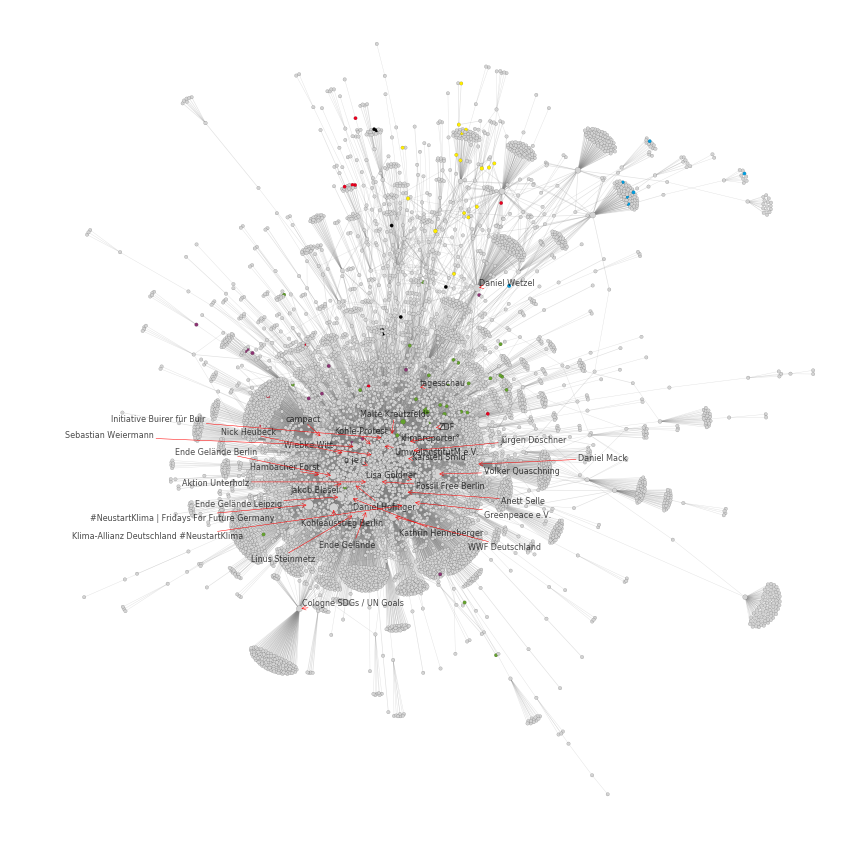

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

draw_network(ax, g, ig_layout, labels[:35])

fig.tight_layout()

plt.savefig('plots/rt_network1.png', bbox_inches="tight")

plt.show()